# Project: Predicting Bike Rentals

## 1: Introduction To The Data Set
Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

[Hadi Fanaee-T](http://www.liaad.up.pt/area/fanaee) at the [University of Porto](http://www.up.pt/) compiled this data into a CSV file, which we will be working with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. The data can be downloaded from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). 

Here are the descriptions for the relevant columns:

* `instant` - A unique sequential ID number for each row
* `dteday` - The date of the rentals
* `season` - The season in which the rentals occurred
* `yr` - The year the rentals occurred
* `mnth` - The month the rentals occurred
* `hr` - The hour the rentals occurred
* `holiday` - Whether or not the day was a holiday
* `weekday` - Whether or not the day was a weekday
* `workingday` - Whether or not the day was a working day
* `weathersit` - The weather (as a categorical variable)
* `temp` - The temperature, on a `0-1` scale
* `atemp` - The adjusted temperature
* `hum` - The humidity, on a `0-1` scale
* `windspeed` - The wind speed, on a `0-1` scale
* `casual` - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
* `registered` - The number of registered riders (people who had already signed up)
* `cnt` - The total number of bike rentals (`casual` + `registered`)

In this project, we will try to predict the total number of bikes people rented in a given hour. We will predict the `cnt` column using all of the other columns, except for `casual` and `registered`. To accomplish this, we will create a few different machine learning models and evaluate their performance.

* Read `bike_rental_hour.csv` into the dataframe `bike_rentals`.
* Print out the first few rows of `bike_rentals` and take a look at the data.
* Make a histogram of the `cnt` column of `bike_rentals`, and take a look at the distribution of total rentals.
* Explore how each column is correlated with `cnt`.

In [5]:
import pandas as pd
bike_rentals = pd.read_csv("data/bike_rental_hour.csv")
print(bike_rentals.head())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  


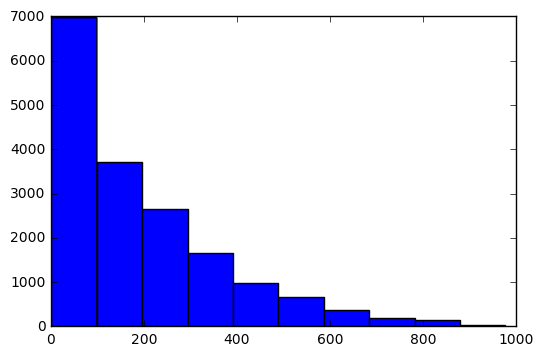

In [6]:
% matplotlib inline 
import matplotlib.pyplot as plt
plt.hist(bike_rentals["cnt"])
plt.show()

In [7]:
bike_rentals.corr()["cnt"]

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

## 2: Calculating Features
The `hr` column in `bike_rentals` contains the hours during which bikes are rented, from `1` to `24`. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for `morning`, `afternoon`, `evening`, and `night`. This will bundle similar times together, enabling the model to make better decisions.

* Write a function called `assign_label` that takes in a numeric value for an hour, and returns:
  * `1` if the hour is from `6` to `12`
  * `2` if the hour is from `12` to `18`
  * `3` if the hour is from `18` to `24`
  * `4` if the hour is from `0` to `6`
* Apply the function to each item in the `hr` column.
* Assign the result to the `time_label` column of `bike_rentals`.

In [8]:
def assign_label(hr):
    if hr >= 6 and hr < 12:
        return 1
    elif hr >= 12 and hr < 18:
        return 2
    elif hr >= 18 and hr < 24:
        return 3
    else:
        return 4

bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)
print(bike_rentals.head())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  \
0           1  0.24  0.2879  0.81        0.0       3          13   16   
1           1  0.22  0.2727  0.80        0.0       8          32   40   
2           1  0.22  0.2727  0.80        0.0       5          27   32   
3           1  0.24  0.2879  0.75        0.0       3          10   13   
4           1  0.24  0.2879  0.75        0.0       0           1    1   

   time_label  
0           4  
1           4  
2           4  
3           4  
4           

## 3: Splitting The Data Into Train And Test Sets
Before we begin applying machine learning algorithms, we will need to split the data into training and testing sets. This will enable us to train an algorithm using the training set, and evaluate its accuracy on the testing set.

* Select 80% of the rows in `bike_rentals` to be part of the training set using the sample method on `bike_rentals`. Assign the result to `train`.
* Select the rows that are in `bike_rentals` but not in train to be in the testing set. Assign the result to `test`.  

### Error metric
Based on the explorations of the `cnt` column, the **mean squared error** metric makes the most sense to evaluate our error. MSE works on continuous numeric data, which fits our data quite well.

In [9]:
train = bike_rentals.sample(frac=.8)
print(train.shape)

(13903, 18)


In [10]:
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]
print(test.shape)

(3476, 18)


## 4: Applying Linear Regression
Now that we have done some exploration and manipulation, we are ready to apply linear regression to the data. Linear regression will probably work fairly well on this data, given that many of the columns are highly correlated with `cnt`.

We will ignore the `casual` and `registered` columns because `cnt` is derived from them. 

* Create a list of predictor columns to use in training and predictions.
  * At a minimum, this list should exclude the `cnt`, `casual`, `dteday`, and `registered` columns.
  * Remove other columns that may not be useful for the predictions.
* Use the LinearRegression class from sklearn to train a machine learning algorithm on `train`.
* Make predictions using the LinearRegression class on `test`.
* Calculate the error between the predictions and the actual values.

In [11]:
predictors = list(train.columns)
print(predictors)
predictors.remove("dteday")
predictors.remove("casual")
predictors.remove("registered")
predictors.remove("cnt")
print(predictors)

['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt', 'time_label']
['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'time_label']


In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
import numpy

lr = LinearRegression()
lr.fit(train[predictors], train["cnt"])
predictions = lr.predict(test[predictors])
lr_mse = mean_squared_error(test["cnt"], predictions)
print(lr_mse)
lr_rmse = lr_mse**(0.5)
print(lr_rmse)

17175.3838106
131.054888541


### Error
The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

## 5: Applying Decision Trees
Now we will apply the decision tree algorithm. We will be able to compare its error with the error from linear regression, which will enable us to pick the right algorithm for this data set.

* Use the `DecisionTreeRegressor` class to fit a decision tree algorithm to the `train` data.
* Make predictions using the `DecisionTreeRegressor` class on `test`.
* Calculate the error between the predictions and the actual values.
* Experiment with various parameters of the `DecisionTreeRegressor` class, including `min_samples_leaf`, to see if it changes the error.

In [13]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
dt.fit(train[predictors], train["cnt"])
dt_pred = dt.predict(test[predictors])
dt_mse = mean_squared_error(test["cnt"], dt_pred)
print(dt_mse)
dt_rmse = dt_mse**(0.5)
print(dt_rmse)

2891.4047756
53.7717841958


#### varying parameter min_samples_leaf

In [14]:
# change parameters
for i in range(5,200,10):
    dt = DecisionTreeRegressor(min_samples_leaf = i)
    dt.fit(train[predictors], train["cnt"])
    dt_pred = dt.predict(test[predictors])
    dt_mse = mean_squared_error(test["cnt"], dt_pred)
    dt_rmse = dt_mse**(0.5)
    print("dt", i, " ", dt_mse, " ", dt_rmse)

dt 5   2322.38664163   48.1911469217
dt 15   2893.35456634   53.7899113806
dt 25   3254.02023327   57.0440201359
dt 35   3726.71158682   61.0467983339
dt 45   4015.61258567   63.3688613254
dt 55   4295.10702288   65.5370660228
dt 65   4472.96970499   66.8802639423
dt 75   4593.73990477   67.7771340849
dt 85   4785.11285979   69.1745101883
dt 95   4998.78031093   70.7020530885
dt 105   5850.30257292   76.4872706593
dt 115   6458.06503624   80.3620870575
dt 125   6727.0504161   82.0185979891
dt 135   6848.79160262   82.7574262687
dt 145   7154.59451042   84.584836173
dt 155   7262.46241932   85.2200822537
dt 165   7498.08049497   86.5914574018
dt 175   7579.10453456   87.0580526692
dt 185   7694.44283078   87.7179732482
dt 195   8167.57638882   90.3746446124


model with min_samples_leaf = 5 gives the least error

#### varying parameter min_samples_split

In [15]:
# change parameters
for i in range(10,200,10):
    dt = DecisionTreeRegressor(min_samples_split = i)
    dt.fit(train[predictors], train["cnt"])
    dt_pred = dt.predict(test[predictors])
    dt_mse = mean_squared_error(test["cnt"], dt_pred)
    dt_rmse = dt_mse**(0.5)
    print("dt", i, " ", dt_mse, " ", dt_rmse)

dt 10   2596.92459347   50.9600293708
dt 20   2436.29253477   49.3588141548
dt 30   2541.48650734   50.4131580774
dt 40   2627.75386803   51.2616217851
dt 50   2691.72832145   51.8818689086
dt 60   2811.77554754   53.0261779458
dt 70   2849.31512871   53.3789764675
dt 80   3003.90430416   54.8078854195
dt 90   3102.76367725   55.7024566537
dt 100   3218.77508029   56.7342496231
dt 110   3295.46667525   57.4061553777
dt 120   3375.92247159   58.102689022
dt 130   3445.90016148   58.7017901046
dt 140   3488.87089455   59.0666648334
dt 150   3648.97381418   60.4067364967
dt 160   3991.91734562   63.1816218977
dt 170   4159.85439012   64.4969331838
dt 180   4235.6520992   65.0818876431
dt 190   4325.38454443   65.767655762


model with min_samples_split = 20 gives the least error

#### varying parameter max_depth

In [16]:
# change parameters
for i in range(2,20):
    dt = DecisionTreeRegressor(max_depth = i)
    dt.fit(train[predictors], train["cnt"])
    dt_pred = dt.predict(test[predictors])
    dt_mse = mean_squared_error(test["cnt"], dt_pred)
    dt_rmse = dt_mse**(0.5)
    print("dt", i, " ", dt_mse, " ", dt_rmse)

dt 2   18230.441343   135.020151618
dt 3   15146.1030959   123.069505142
dt 4   13155.1821973   114.69604264
dt 5   11211.0594386   105.882290486
dt 6   10018.2605251   100.091260983
dt 7   6633.49242771   81.4462548415
dt 8   4927.8883446   70.198919825
dt 9   3924.78912468   62.6481374398
dt 10   3315.17800755   57.5775825087
dt 11   3119.47897089   55.8522960216
dt 12   2821.80303433   53.1206460271
dt 13   2771.97295594   52.649529494
dt 14   2686.35918879   51.8300992551
dt 15   2724.42668464   52.1960408905
dt 16   2750.6212788   52.4463657349
dt 17   2847.03395678   53.3576044887
dt 18   2880.88284554   53.6738562574
dt 19   2938.29795232   54.206069331


model with max_depth = 14 gives the least error

#### varying parameter min_samples_split while keeping max_depth at 13 and min_samples_leaf at 5

In [17]:
# change parameters
for i in range(1,50,1):
    dt = DecisionTreeRegressor(max_depth = 13, min_samples_leaf = 5, min_samples_split = i)
    dt.fit(train[predictors], train["cnt"])
    dt_pred = dt.predict(test[predictors])
    dt_mse = mean_squared_error(test["cnt"], dt_pred)
    dt_rmse = dt_mse**(0.5)
    print("dt", i, " ", dt_mse, " ", dt_rmse)

dt 1   2428.44784481   49.2792841345
dt 2   2420.1104081   49.1946176741
dt 3   2419.82762454   49.191743459
dt 4   2427.12652093   49.2658758263
dt 5   2432.45740434   49.3199493546
dt 6   2426.95299538   49.2641146818
dt 7   2430.82736875   49.303421471
dt 8   2431.14412902   49.3066337223
dt 9   2427.45040588   49.2691628291
dt 10   2429.96923974   49.2947181729
dt 11   2408.0155484   49.0715350116
dt 12   2429.4332313   49.2892810994
dt 13   2423.56693611   49.2297362994
dt 14   2423.93458679   49.2334701884
dt 15   2406.12766794   49.0522952362
dt 16   2415.58284864   49.1485793146
dt 17   2430.89589361   49.3041163962
dt 18   2409.2759553   49.0843758776
dt 19   2415.47445657   49.1474766043
dt 20   2437.4923736   49.3709669097
dt 21   2441.15590144   49.4080550258
dt 22   2444.73128781   49.4442240086
dt 23   2437.75848968   49.3736619026
dt 24   2438.39276797   49.3800847303
dt 25   2480.42728107   49.8038882124
dt 26   2486.61778508   49.8659982862
dt 27   2491.86491923   49.9

model with max_depth = 13, min_samples_leaf = 12 and min_samples_split = 15 gives the least error **_2406.13_**

## 6: Applying Random Forests
We can now apply the random forest algorithm, which improves on the decision tree algorithm. 

* Use the `RandomForestRegressor` class to fit a random forest algorithm to the `train` data.
* Make predictions using the `RandomForestRegressor` class on `test`.
* Calculate the error between the predictions and the actual values.
* Experiment with various parameters of the `RandomForestRegressor` class, including `min_samples_leaf`, to see if it changes the error.

In [18]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor()
reg.fit(train[predictors], train["cnt"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [19]:
predictions = reg.predict(test[predictors])
numpy.mean((predictions - test["cnt"]) ** 2)

1705.348481012659

Random forest model gives lower error than the Decision Tree models.
**_1705.35_**

#### varying parameter min_samples_split

In [20]:
# change parameters
for i in range(1,25,1):
    reg = RandomForestRegressor(max_depth = None, min_samples_leaf = 1, min_samples_split = i)
    reg.fit(train[predictors], train["cnt"])
    reg_pred = reg.predict(test[predictors])
    reg_mse = mean_squared_error(test["cnt"], reg_pred)
    reg_rmse = reg_mse**(0.5)
    print("reg", i, " ", reg_mse, " ", reg_rmse)

reg 1   1748.01622842   41.809283998
reg 2   1727.78950518   41.5666874453
reg 3   1750.6574962   41.8408591714
reg 4   1751.99948143   41.8568928784
reg 5   1748.35082071   41.8132852179
reg 6   1700.47559927   41.2368233412
reg 7   1725.69861917   41.5415288497
reg 8   1727.20107656   41.5596087152
reg 9   1748.84872868   41.8192387387
reg 10   1776.39809419   42.1473379253
reg 11   1774.12188684   42.1203262908
reg 12   1830.21303718   42.780989203
reg 13   1779.93938216   42.1893278231
reg 14   1972.8792861   44.4171057826
reg 15   1907.55489324   43.6755640289
reg 16   1918.3308147   43.7987535747
reg 17   1842.63088452   42.9258766308
reg 18   1954.9526149   44.2148460916
reg 19   1894.18670188   43.5222552481
reg 20   1939.19253469   44.0362638594
reg 21   1899.24077825   43.5802796945
reg 22   1890.85119838   43.483918848
reg 23   2002.40888105   44.7482835543
reg 24   1964.93543384   44.3275922405


model with min_samples_split = 6 gives the least error **_1700.47_**

#### varying parameter min_samples_leaf while keeping max_depth at None and min_samples_split at 7

In [21]:
# change parameters
for i in range(1,25,1):
    reg = RandomForestRegressor(max_depth = None, min_samples_leaf = i, min_samples_split = 2)
    reg.fit(train[predictors], train["cnt"])
    reg_pred = reg.predict(test[predictors])
    reg_mse = mean_squared_error(test["cnt"], reg_pred)
    reg_rmse = reg_mse**(0.5)
    print("reg", i, " ", reg_mse, " ", reg_rmse)

reg 1   1805.56425201   42.4919316108
reg 2   1707.23960587   41.3187561026
reg 3   1705.44911636   41.2970836302
reg 4   1835.76698609   42.8458514454
reg 5   1817.42519852   42.631270196
reg 6   1959.09054252   44.2616147754
reg 7   2092.73408347   45.7464106075
reg 8   2162.33707519   46.5009362829
reg 9   2205.57634254   46.9635639889
reg 10   2222.86659142   47.1472861512
reg 11   2257.15608721   47.5095368027
reg 12   2334.96931367   48.321520192
reg 13   2457.92898054   49.5775047833
reg 14   2597.77657462   50.9683879932
reg 15   2654.03617346   51.5173385712
reg 16   2671.30347539   51.6846541576
reg 17   2640.64782659   51.387234082
reg 18   2843.3200758   53.3227913354
reg 19   2804.10130941   52.9537657718
reg 20   2798.98570464   52.9054411629
reg 21   2982.11320566   54.6087282919
reg 22   2998.45185067   54.7581213216
reg 23   2934.62119976   54.1721441311
reg 24   3097.90340106   55.6588124295


model with min_samples_leaf = 2 gives the least error **_1707.24_**

In [24]:
reg = RandomForestRegressor(max_depth = None, min_samples_leaf = 2, min_samples_split = 7)
reg.fit(train[predictors], train["cnt"])
reg_pred = reg.predict(test[predictors])
reg_mse = mean_squared_error(test["cnt"], reg_pred)
reg_rmse = reg_mse**(0.5)
print(reg_mse, " ", reg_rmse)

reg 24   1604.11478251   40.0514017547


Varying the parameters helps lower the error even further to 1604.11. Random Forest gives much better results than the other models.